In [1]:
import statistics

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_table("Datasets/corr_spearman_matrix.txt", sep='\t')

### Parsing a little error in the correlation dataset

In [3]:
corr_values = df['Correlation']

for index, value in enumerate(corr_values):
    if '(' not in value:
        corr_values[index] = float(value)
    else:
        corr_values[index] = float(value.split(', ')[0].replace('(', ''))

df['Correlation'] = corr_values

### Plotting the features distribution

In [4]:
def dist_variavel(x, title):
    
    fig, ax = plt.subplots(1,1, figsize=(20,10)) 

    ax.set_title('Distribution ' + title)

    sns.distplot((x), ax = ax, norm_hist=False)
    #plt.hist(x, 20)

    #plt.figure(figsize=(20, 10))
    xticks = [value/10 for value in range(-10, 10)]
    plt.xticks(xticks)
    plt.xlabel("Correlation")
    plt.ylabel("Probability Density")
    plt.grid(True)
    plt.show()


def plot_ccdf(x, title = ''):
    
    #colors = list(mcolors.CSS4_COLORS.keys())
    fig, ax = plt.subplots(figsize=(15,7))
    bins = 100
    cnt_color = 11
    legends = []



    #cdf = your_data.cumsum(0)
    #ccdf = 1 - cdf
    ccdf = x
    ax.hist(ccdf, bins=bins, density=True, histtype='step', linewidth=3,cumulative=-1, label='Empirical')
    legends.append('Penalties - PK Attempt')


    ax.set_title('CCDF - ' + title)
    ax.set_xlabel('Correlation')
    #plt.xlim(0,50)
    #plt.xticks(range(0,50,5))

    ax.grid(True)
    ax.set_ylabel('Occurence Probability')
    #plt.yticks(np.arange(0,1.0,0.1), fontsize=24)
    plt.legend(legends)
    

In [5]:
positions, feature_set = set(df['Position']), set(df['Feature Set'])

# removing nan values
df = df.dropna(axis=0, how='any')
df = df.loc[df['Correlation'] != -2]

# Statistic Features
keys = ['Mean', 'Median', '10 Percentile', '25 Percentile', '75 Percentile', '90 Percentile']
statistic_features = {}
for key in keys:
    statistic_features[key] = []

# I will save the player and the pair of features
keys = ['Players 10', 'Players 90', 'Corr 10', 'Corr 90', 'Pair 10', 'Pair 90']
main_players = {}
for key in keys:
    main_players[key] = []


players_complete = set(list(df['Name']))
players = {player: {} for player in players_complete}
for feature in feature_set:
    fifa_features = set(df.loc[df['Feature Set'] == feature]['Feature One'])
    for fifa in fifa_features:
        ref_features = set(df.loc[df['Feature Set'] == feature]['Feature Two'])
        for ref in ref_features:
            title =  fifa + ' - ' + ref
            eva_df = df.loc[(df['Feature One'] == fifa) & (df['Feature Two'] == ref)]
            statistic_features['Mean'].append(statistics.mean(eva_df['Correlation']))
            statistic_features['Median'].append(statistics.median(eva_df['Correlation']))
            statistic_features['10 Percentile'].append(np.percentile(eva_df['Correlation'], 10))
            statistic_features['25 Percentile'].append(np.percentile(eva_df['Correlation'], 25))
            statistic_features['75 Percentile'].append(np.percentile(eva_df['Correlation'], 75))
            statistic_features['90 Percentile'].append(np.percentile(eva_df['Correlation'], 90))
            
            per = np.percentile(eva_df['Correlation'], 90)
            index = round( (len(eva_df['Correlation']) - 1) * (90 / 100.) )
            if per >= 0.3:
                teste = sorted(eva_df['Correlation'])
                corr_value = eva_df.loc[eva_df['Correlation'] == teste[index]]['Name'].values[0]
                main_players['Players 90'].append(corr_value)
                main_players['Pair 90'].append(title)
                main_players['Corr 90'].append(per)
            
            
            per = np.percentile(eva_df['Correlation'], 10)
            index = round( (len(eva_df['Correlation']) - 1) * (10 / 100.) )
            if per <= -0.3:
                teste = sorted(eva_df['Correlation'])
                corr_value = eva_df.loc[eva_df['Correlation'] == teste[index]]['Name'].values[0]
                main_players['Players 10'].append(corr_value)
                main_players['Pair 10'].append(title)
                main_players['Corr 10'].append(per)
    
            df_players = set(eva_df['Name'])
            for player in players.keys():
                if player not in df_players:
                    players[player][title] = 0
                else:
                    players[player][title] = max(eva_df.loc[eva_df['Name'] == player]['Correlation'].values)

In [ ]:
for key in statistic_features.keys():
    dist_variavel(statistic_features[key], key)

### HeatMap

In [ ]:
x_labels  = players['Pedro'].keys()
y_labels = players.keys()
matrix = []

for player in players.keys():
    matrix.append(list(players[player].values()))


fig, ax = plt.subplots(1,1, figsize=(30,30))
plot = sns.heatmap(matrix, xticklabels = x_labels, yticklabels = y_labels, linewidths=.3,  cmap="YlGnBu")
sns.set(font_scale = 2)
plot.axes.set_title("Correlation for Players and Pair of Features",fontsize=30)
plot.set_xlabel("Pair of features", fontsize = 30)
plot.set_ylabel("Players", fontsize = 30)

In [6]:
def count_instances(list_values):

    counter = {value: 0 for value in list_values}
    for value in set(list_values):
        counter[value] = len(list(filter(lambda x: value == x, list_values)))
    
    return counter

def evaluate_percentiles(features, main_players):
    
    for feature in features:

        if 'Player' in feature:
            player = count_instances(main_players[feature])
        elif 'Corr' in feature:
            corr = count_instances(main_players[feature])
        elif 'Pair' in feature:
            pair = count_instances(main_players[feature])
    
    return {**player, **corr, **pair}

In [14]:
def table_values(df, name):
    x = df.loc[df['Players 10'] == name]
    
    return len(x), round(min(x['Corr 10']), 3), round(max(x['Corr 10']),3), x.loc[x['Corr 10'] == min(x['Corr 10'])]['Pair 10'].values[0]
    
    


features_10 = list(filter(lambda x: '10' in x, main_players.keys()))
features_90 = list(filter(lambda x: '90' in x, main_players.keys()))
#print(len(set(main_players['Players 10'])))
#evaluate_percentiles(features_10, main_players)
df_ten = pd.DataFrame()
df_nine = pd.DataFrame()
for key_10, key_90 in zip(features_10, features_90):
    df_ten[key_10] = main_players[key_10]
    df_nine[key_90] = main_players[key_90]

print(len(set(df_nine['Players 90'])))
table_values(df_ten, 'Pedro')
#df_ten.head(5)

28


(6, -0.73, -0.594, 'Marking - Tackles Won')

### Second Phase: Public Opinion Analysis

In [15]:
df_comments = pd.read_table("Datasets/comments_spearman.txt", sep='\t')

In [16]:
df_comments.dropna(how='any', inplace=True)

In [17]:
statistics.mean(df_comments['Correlation'])

0.12024749617753554

In [23]:
df_comments.loc[(df_comments['Correlation'] >=0.3) | (df_comments['Correlation'] <= -0.3)]

print(len(set(x['Name'])))

16


/usr/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


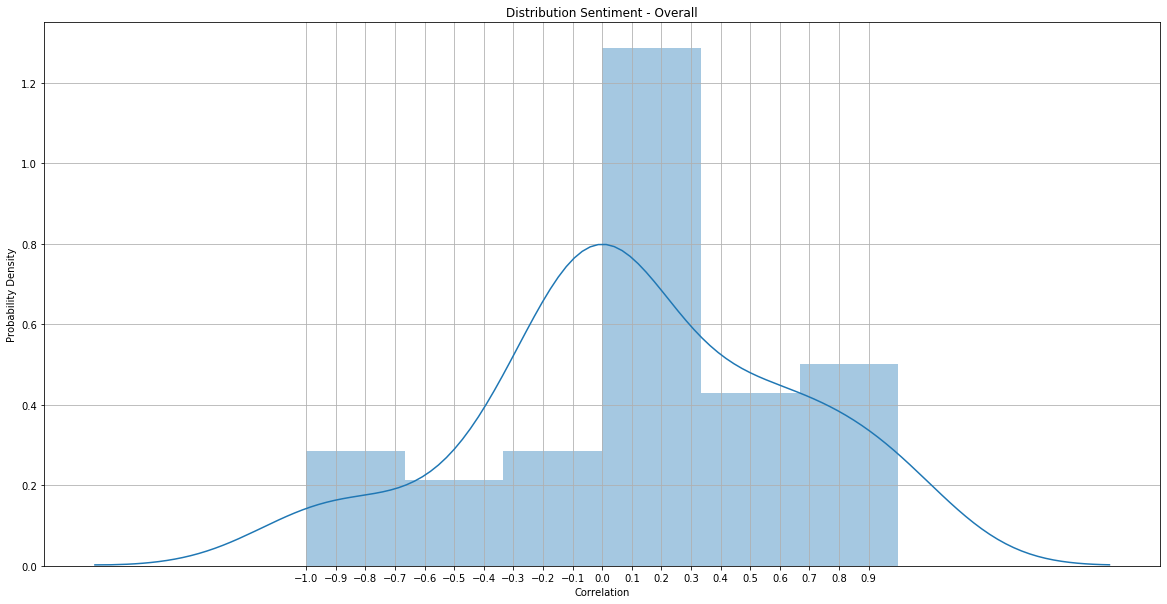

In [13]:
dist_variavel(df_comments['Correlation'], "Sentiment - Overall")

In [26]:
x

,Name,Correlation,Feature One,Feature Two,Feature Set,Position
17,Álvaro Morata,-0.826334,Overall,Sentiment,Sentiment,ST
26,Radamel Falcao,-0.339467,Overall,Sentiment,Sentiment,ST
35,Isco,0.670820,Overall,Sentiment,Sentiment,LW
42,Juan Cuadrado,0.447214,Overall,Sentiment,Sentiment,RM
56,David Luiz,-1.000000,Overall,Sentiment,Sentiment,RCB
60,Bastian Schweinsteiger,-0.478091,Overall,Sentiment,Sentiment,SUB
65,Javier Hernández,1.000000,Overall,Sentiment,Sentiment,SUB
67,Zlatan Ibrahimovic,0.948683,Overall,Sentiment,Sentiment,SUB
80,Jack Wilshere,0.573805,Overall,Sentiment,Sentiment,SUB
82,Pedro,-0.385467,Overall,Sentiment,Sentiment,SUB
